# Reading Dutch Datasets

One of the biggest challenges when making a Pastas Model is to find a valid dataset. The hydropandas packages can be used to obtain such a dataset. This notebook shows how to build a simple pastas model from Dutch data. 

1. [Groundwater observations](#Groundwater-observations)
2. [Meteo observations](#Meteo-observations)
3. [Pastas model](#Pastas-model)
4. [Surface water observations](#Surface-water-observations)

More information for obtaining Dutch datasets using hydropandas can be found here -> https://hydropandas.readthedocs.io/ 

In [1]:
import hydropandas as hpd
import pastas as ps

ps.show_versions()

Python version: 3.9.4 (default, Apr  9 2021, 11:43:21) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Scipy version: 1.8.1
Pandas version: 1.4.3
Pastas version: 0.21.0
Matplotlib version: 3.5.1


## Groundwater observations

First we read the groundwater level observation using the `read_dino` function of a `GroundwaterObs` object. The code below reads the groundwater level timeseries from a csv file in the data directory.

In [2]:
gw_levels = hpd.GroundwaterObs.from_dino(r'../data/B49F0555001_1.csv')

Note that `gw_levels` is a `GroundwaterObs` object. This is basically a pandas DataFrame with additional methods and attributes related to groundwater level observations. We can print `gw_levels` to see all of its properties.

In [3]:
print('groundwater levels')
print(gw_levels)

groundwater levels
-----metadata------
name : B49F0555-001 
x : 94532.0 
y : 399958.0 
meta : {'locatie': 'B49F0555', 'x': 94532.0, 'y': 399958.0, 'filternr': 1.0, 'meetpunt': -0.15, 'bovenkant_filter': -0.75, 'onderkant_filter': -1.75, 'maaiveld': -0.61, 'name': 'B49F0555-001', 'metadata_available': True, 'filename': '../data/B49F0555001_1.csv'} 
filename : ../data/B49F0555001_1.csv 
locatie : B49F0555 
filternr : 1.0 
bovenkant_filter : -0.75 
onderkant_filter : -1.75 
maaiveld : -0.61 
meetpunt : -0.15 
metadata_available : True 

-----observations------
             locatie  filternummer  stand_cm_tov_mp  stand_cm_tov_mv  \
peildatum                                                              
2003-02-14  B49F0555             1             49.0              3.0   
2003-02-26  B49F0555             1             56.0             10.0   
2003-03-14  B49F0555             1             66.0             20.0   
2003-03-28  B49F0555             1             77.0             31.0   
2003

The `GroundwaterObs` object comes with its own plot methods, to quickly visualize the data:

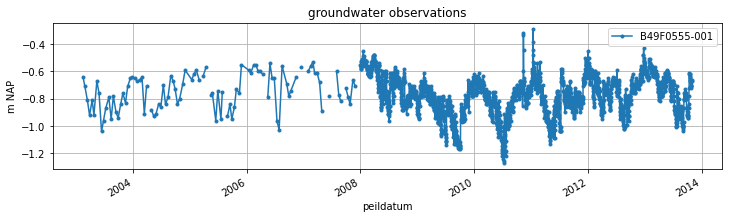

In [4]:
ax = gw_levels['stand_m_tov_nap'].plot(figsize=(12,3), marker='.', grid=True, label=gw_levels.name, legend=True, ylabel='m NAP', title='groundwater observations')

## Meteo observations
We can obtain evaporation and precipitation data from the knmi using the `from_nearest_xy` method in hydropandas. For a given set of (x,y) coordinates it will find the closest KNMI meteostation and download the data. If there are missing measurements they are filled automatically using the value of a nearby station.

In [5]:
evaporation = hpd.EvaporationObs.from_nearest_xy((gw_levels.x, gw_levels.y), 'EV24', startdate=gw_levels.index[0], enddate=gw_levels.index[-1])
precipitation = hpd.PrecipitationObs.from_nearest_xy((gw_levels.x, gw_levels.y), startdate=gw_levels.index[0], enddate=gw_levels.index[-1])

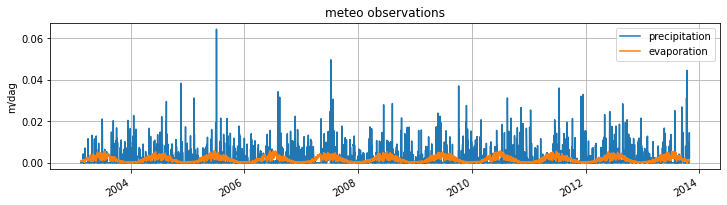

In [6]:
ax = precipitation['RH'].plot(label='precipitation', legend=True, figsize=(12,3))
evaporation['EV24'].plot(ax=ax, label='evaporation', legend=True, grid=True, ylabel='m/dag', title='meteo observations');

## Pastas model

Now that we have groundwater observations and meteo data we can create a Pastas model.

In [7]:
ml = ps.Model(gw_levels['stand_m_tov_nap'], name=gw_levels.name)

# Add the recharge data as explanatory variable
ts1 = ps.RechargeModel(precipitation['RH'], evaporation['EV24'], ps.Gamma, name='rainevap', 
                       recharge=ps.rch.Linear(), settings=("prec", "evap"))

ml.add_stressmodel(ts1)

ml.solve(tmin='2009')

INFO: Cannot determine frequency of series B49F0555-001: freq=None. The time series is irregular.
INFO: Time Series B49F0555-001: 14 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series RH_WOENSDRECHT: freq=D
INFO: Inferred frequency for time series EV24_GILZE-RIJEN: freq=D
INFO: Time Series RH_WOENSDRECHT was extended to 1999-01-04 01:00:00 with the mean value of the time series.
INFO: Time Series EV24_GILZE-RIJEN was extended to 1999-01-04 01:00:00 with the mean value of the time series.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Fit report B49F0555-001            Fit Statistics
nfev    35                     EVP          58.89
nobs    1763                   R2            0.59
noise   True                   RMSE          0.09
tmin    2009-01-01 00:00:00    AIC      -11436.22
tmax    2013-10-30 00:00:00    BIC      -11403.37
freq    D                      Obj           1.33
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.        Yes

Parameters (6 optimized)
               optimal   stderr     initial  vary
rainevap_A   38.339244  ±13.29%  201.185004  True
rainevap_n    0.725369   ±4.43%    1.000000  True
rainevap_a   17.600900  ±23.22%   10.000000  True
rainevap_f   -2.000000  ±12.49%   -1.000000  True
constant_d   -0.753227   ±1.96%   -0.774436  True
noise_alpha   9.601801   ±9.87%    1.000000  True

Warnings! (1)
Parameter 'rainevap_f' on lower bound: -2.00e+00


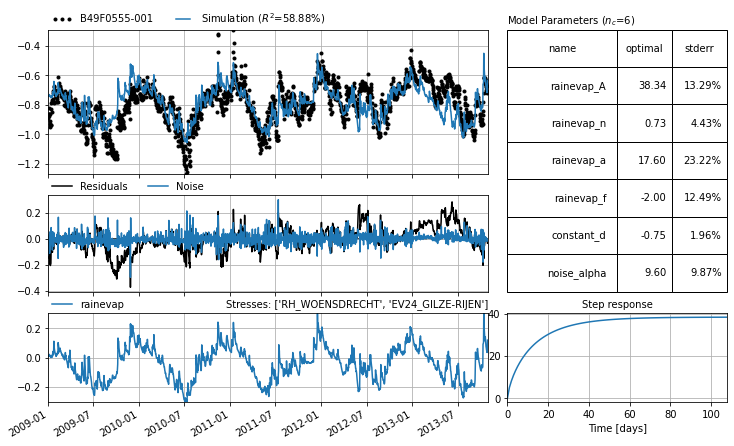

In [8]:
ml.plots.results(figsize=(10, 6));

## Surface water observations

Our model is not always able to simulate the groundwater level accurately. Maybe it will improve if we add surface water observations. The code below is used to read the surface water level timeseries from a csv file in the data directory.

In [9]:
river_levels = hpd.WaterlvlObs.from_dino(r'../data/P43H0001.csv')

We can plot the data together with the groundwater levels.

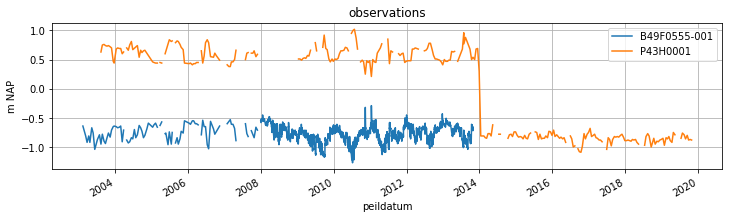

In [10]:
ax = gw_levels['stand_m_tov_nap'].plot(figsize=(12,3), label=gw_levels.name, ylabel='m NAP', title='observations', legend=True)
river_levels['stand_m_tov_nap'].plot(ax=ax, grid=True, label=river_levels.name, legend=True);

As can be observed in the plot above, there is a downward shift in the surface water levels at the end of 2014. Clearly something went wrong with the registration of the river levels. We assume that the negative values from the end of 2014 onwards are correct. The positive values were registered incorrectly (missing a minus sign). We fix the timeseries by updating the 'stand_m_tov_nap' column of the `WaterlvlObs` object named `river_levels`. 

In [11]:
river_levels['stand_m_tov_nap'] = river_levels['stand_m_tov_nap'].abs() * -1

Now we plot the timeseries again, to see if the applied fix looks reasonable.

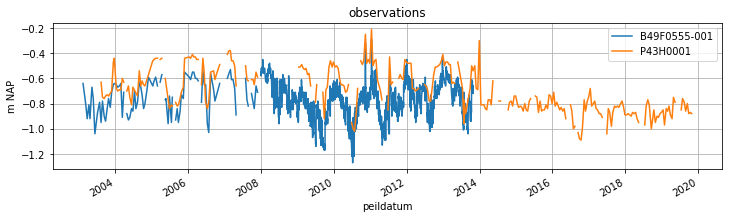

In [12]:
ax = gw_levels['stand_m_tov_nap'].plot(figsize=(12,3), label=gw_levels.name, ylabel='m NAP', title='observations', legend=True)
river_levels['stand_m_tov_nap'].plot(ax=ax, grid=True, label=river_levels.name, legend=True);

Now we add the river levels as an external stress in the pastas model.

INFO: Cannot determine frequency of series P43H0001: freq=None. Resample settings are ignored and timestep_weighted_resample is used.
INFO:pastas.timeseries:Cannot determine frequency of series P43H0001: freq=None. Resample settings are ignored and timestep_weighted_resample is used.
INFO: Time Series P43H0001: 49 nan-value(s) was/were found and filled with: drop.
INFO:pastas.timeseries:Time Series P43H0001: 49 nan-value(s) was/were found and filled with: drop.
INFO: Time Series P43H0001 was sampled down to freq D with method timestep_weighted_resample.
INFO:pastas.timeseries:Time Series P43H0001 was sampled down to freq D with method timestep_weighted_resample.
INFO: Time Series P43H0001 was sampled down to freq D with method timestep_weighted_resample.
INFO:pastas.timeseries:Time Series P43H0001 was sampled down to freq D with method timestep_weighted_resample.
INFO: Time Series P43H0001 was extended to 1999-01-04 01:00:00 with the mean value of the time series.
INFO:pastas.timeserie

Fit report B49F0555-001                 Fit Statistics
nfev    33                     EVP               75.99
nobs    1763                   R2                 0.76
noise   True                   RMSE               0.07
tmin    2009-01-01 00:00:00    AIC           -11450.44
tmax    2013-10-30 00:00:00    BIC           -11412.12
freq    D                      Obj                1.32
warmup  3650 days 00:00:00     ___                    
solver  LeastSquares           Interp.             Yes

Parameters (7 optimized)
                   optimal    stderr     initial  vary
rainevap_A     1212.102477   ±95.65%  201.185004  True
rainevap_n        0.602269    ±3.32%    1.000000  True
rainevap_a    10000.000000  ±186.60%   10.000000  True
rainevap_f       -1.032730   ±12.64%   -1.000000  True
waterlevel_d      0.143473   ±17.84%    0.169177  True
constant_d       -1.050526   ±12.13%   -0.774436  True
noise_alpha       5.200575    ±7.70%    1.000000  True

Warnings! (2)
Parameter 'rainevap_a' o

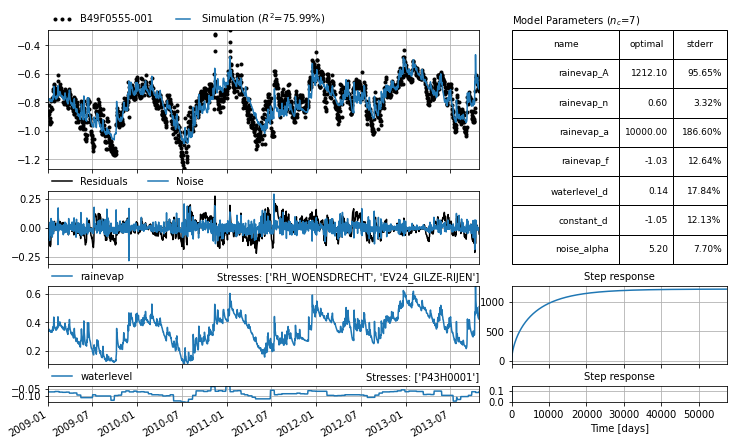

In [13]:
w = ps.StressModel(river_levels['stand_m_tov_nap'], rfunc=ps.One,  name="waterlevel", 
                   settings="waterlevel")
ml.add_stressmodel(w)
ml.solve(tmin='2009')

ml.plots.results(figsize=(10, 6));

We can see that the evp has increased when we've added the water level stress, does this mean that the model improved? Please see the notebooks on [diagnostic checking](03_diagnostic_checking.ipynb) and [uncertainty](16_uncertainty.ipynb) for more information on this subject.